In [1]:
#@title Install arviz
# !pip3 install arviz

In [2]:
import arviz as az
import pystan
import os
# os.environ['STAN_NUM_THREADS'] = "4"
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

## Select model


        About: 

        SIR model - expects I only 

        fits I (assumes I=C) only
        
S: susceptible
I: infected
RD: recovered_dead


/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


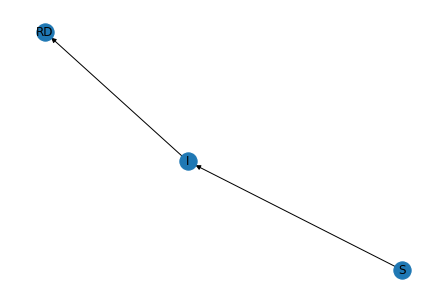

In [3]:
import MBS_epidemic_concentration_models as models
model = models.model_sir1()
model.plotnetwork()

## Compile

In [4]:
stanrunmodel = pystan.StanModel(model_code=model.stan)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cb02a5197f1c91fd6a767799c0ef8614 NOW.


# Load data from JHU



In [5]:
url_confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
url_deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
url_recovered = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"

dfc = pd.read_csv(url_confirmed)
dfd = pd.read_csv(url_deaths)
dfr = pd.read_csv(url_recovered)




## Make JHU ROI DF

### Enter country 

In [6]:
#Austria,Belgium,Denmark,France,Germany,Italy,Norway,Spain,Sweden,Switzerland,United Kingdom
roi = "France"

t0 assumed to be: day 9


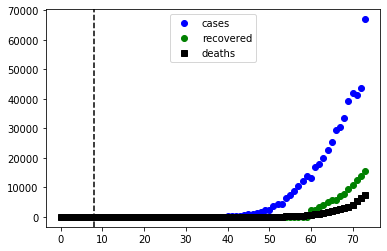

In [7]:
dfc2 = dfc.loc[(dfc['Country/Region']==roi)&(pd.isnull(dfc['Province/State']))]
dfd2 = dfd.loc[(dfd['Country/Region']==roi)&(pd.isnull(dfd['Province/State']))]
dfr2 = dfr.loc[(dfr['Country/Region']==roi)&(pd.isnull(dfr['Province/State']))]


DF = df = pd.DataFrame(columns=['date','cases','recovered','deaths'])

dates = dfc.columns[4:].values

for i in range(len(dates)):
  DF.loc[i] = pd.Series({'date':dates[i],
                         'cases':dfc2[dates[i]].values[0] - (dfr2[dates[i]].values[0] + dfd2[dates[i]].values[0]),
                         'recovered':dfr2[dates[i]].values[0],
                         'deaths':dfd2[dates[i]].values[0]})


pop = {}
pop['Italy'] = 60500000
pop['United Kingdom'] = 64400000
pop['France'] = 66990000

t0 = np.where(DF["cases"].values>5)[0][0] - 1# estimated day of first exposure? Need to make this a parameter
model.stan_data['t0'] = t0-1
print("t0 assumed to be: day "+str(t0))
plt.plot(DF["cases"],'bo', label="cases")
plt.plot(DF["recovered"],'go',label="recovered")
plt.plot(DF["deaths"],'ks',label="deaths")

plt.axvline(model.stan_data['t0'],color='k', linestyle="dashed")
plt.legend()


## Format JHU ROI data for Stan

In [8]:
#truncate time series from t0 on (initial is t0-1)
model.stan_data['ts'] = np.arange(t0,len(dates))  
model.stan_data['y'] = (DF[['cases','recovered','deaths']].to_numpy()).astype(int)[t0:,:]
model.stan_data['n_obs'] = len(dates) - t0

### Enter population manually

In [9]:
model.stan_data['n_pop'] = pop[roi] 
model.stan_data['n_scale'] = 10000000


### Print data for Stan 

In [10]:
print(model.stan_data)

{'n_theta': 2, 'n_difeq': 3, 'n_ostates': 3, 't0': 8, 'ts': array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
       26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
       60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]), 'y': array([[    5,     0,     0],
       [    6,     0,     0],
       [    6,     0,     0],
       [    6,     0,     0],
       [    6,     0,     0],
       [    6,     0,     0],
       [    6,     0,     0],
       [    6,     0,     0],
       [   11,     0,     0],
       [   11,     0,     0],
       [   11,     0,     0],
       [   11,     0,     0],
       [    9,     2,     0],
       [    9,     2,     0],
       [    9,     2,     0],
       [    7,     4,     1],
       [    7,     4,     1],
       [    7,     4,     1],
       [    7,     4,     1],
       [    7,     4,     1],
       [    7,     4,     1],
       [    7, 

# Load England School 1978 Influenza data 

In [11]:
# #England 1978 influenza
# cases = [0,8,26,76,225,298,258,233,189,128,150,85,14,4]
# recovered = [0,0,0,0,9,17,105,162,176,166,150,85,47,20]
# plt.plot(cases,'bo', label="cases")
# plt.plot(recovered,'go',label="recovered")
# pop = 763
# model.stan_data['t0'] = 0
# #truncate time series from t0 on (initial is t0-1)
# model.stan_data['n_pop'] = pop 
# model.stan_data['ts'] = np.arange(1,len(cases)+1)  
# Y = np.hstack([np.c_[cases],np.c_[recovered],np.zeros((len(cases),1))]).astype(int)
# model.stan_data['y'] = Y
# model.stan_data['n_obs'] = len(cases)

# plt.plot(cases,'bo', label="cases")
# plt.plot(recovered,'go',label="recovered")

# plt.legend()

# Run Stan 

## Initialize parameters

In [12]:
# Feed in some feasible initial values to start from

# init_par = [{'theta':[0.25,0.01,0.01,0.05,.02],'S0':0.5}] 


if model.name in ["sir1","sir2"]:
    def init_fun():
        x = {'theta':
             [0.5*np.random.uniform()]+
             [0.1*np.random.uniform()]
            }
        return x

if model.name in ["sicu"]:
    def init_fun():
        x = {'theta':
             [0.1*np.random.uniform()]+
             [0.1*np.random.uniform()]+
             [0.5*np.random.uniform()]+
             [0.1*np.random.uniform()]
            }
        return x
    
if model.name in ["sicuq","sicuf"]:
    def init_fun():
        x = {'theta':
             [0.1*np.random.uniform()]+
             [0.1*np.random.uniform()]+
             [0.5*np.random.uniform()]+
             [0.1*np.random.uniform()]+
             [0.1*np.random.uniform()]
            }
        return x
    
if model.name in ["sicrq"]:
    def init_fun():
        x = {'theta':
             [0.1*np.random.uniform()]+
             [0.1*np.random.uniform()]+
             [0.1*np.random.uniform()]+
             [0.1*np.random.uniform()]+
             [0.5*np.random.uniform()]+
             [0.1*np.random.uniform()]}
        return x

## Fit Stan 

In [ ]:
n_chains=12
n_warmups=500
n_iter=20000
n_thin=10

control = {'adapt_delta':0.95}
fit = stanrunmodel.sampling(data = model.stan_data,init = init_fun,control=control, chains = n_chains, warmup = n_warmups, iter = n_iter, thin=n_thin, seed=13219)



In [ ]:
print(fit)

In [ ]:
#https://arviz-devs.github.io/arviz/generated/arviz.plot_density
az.plot_density(fit,group='posterior',var_names=["theta","R_0"])

In [ ]:
ms=2 
x = range(len(fit.extract()['u'][-1,:,0]))

if model.name in ["sir1","sir2"]:
    plt.plot(x,DF["cases"][t0:],'bo', label="cases",ms=ms)
    plt.plot(x,DF["recovered"][t0:] + DF["deaths"][t0:],'o',color='orange',label="unknown",ms=ms)
    labels = ["S","I","U","Z"]
    c_ = ["g","b","orange","r"]
    Sind = 0
    n = 3

if model.name in ["sicu","sicuf","sicuq"]:
    plt.plot(x,DF["cases"][t0:],'bo', label="cases",ms=ms)
    plt.plot(x,DF["recovered"][t0:] + DF["deaths"][t0:],'o',color='orange',label="unknown",ms=ms)
    labels = ['C','U','I','S','Z']
    c_ = ['b','orange','r','g','m']
    n = 4

if model.name in ["sicrq"]:
    plt.plot(x,DF["cases"][t0:],'bo', label="cases",ms=ms)
    plt.plot(x,DF["recovered"][t0:],'o',color='orange',label="unknown",ms=ms)
    plt.plot(x,DF["deaths"][t0:],'x',color='k',label="unknown",ms=ms)
    labels = ['C','R','D','I','S','Z']
    c_ = ['b','orange','k','r','g','m']
    n = 5   
    
lw=4
a = 0.5
for i in range(n):
    plt.plot(model.stan_data['n_scale']*fit.extract()['u'][-1,:,i],label=labels[i],lw=lw,alpha=a,color=c_[i])
plt.plot(model.stan_data['n_scale']*(1-fit.extract()['u'][-1,:,Sind]),label=labels[-1],lw=lw,alpha=a,color=c_[-1])
plt.legend()
plt.ylim((0,100000))

# labels = ['C','D','R','I','S','Z']
# lw=4
# a = 0.5
# for i in range(5):
#     plt.plot(model.stan_data['n_scale']*fit.extract()['u'][-1,:,i],label=labels[i],lw=lw,alpha=a)
# plt.plot(model.stan_data['n_scale']*(1-fit.extract()['u'][-1,:,4]),label=labels[-1],lw=lw,alpha=a)
# plt.legend()
# plt.ylim((0,100000))

# # plt.subplot(1,2,2)
# # tot = DF["cases"][-1:] + DF["recovered"][-1:] + DF["deaths"][-1:]

# # plt.axvline(model.stan_data['t0'],color='k', linestyle="dashed")
# plt.legend()
# plt.title(roi)
# plt.figure()
# # plt.plot(fit.extract()['lp__'])
# az.plot_density(fit,group='posterior',var_names=["theta","R_0"])



In [ ]:
az.plot_pair(fit,var_names=["theta"], divergences=True)